>TOC
```
Step 1. 데이터 불러오기
Step 2. 종가 데이터
     2-1. 차트 시각화
     2-2. 자기상관성
Step 3. 차분 데이터
     3-1. 차분 데이터 시각화
     3-2. 차분 데이터의 자기상관성
     3-3. 정상성
Step 4. 결론
```

재무제표에 대한 이해나 기술적 전략이 부재한 경우, 즉 볼 수 있는 데이터가 '주가'에 한정되어 있는 경우에는 일반적으로 '단타'와 '장기 보유'라는 2가지 선택이 가능합니다.

둘 중 통계적으로 예측 가능성이 더 높은 쪽은 어디일까요? 사실, 경험적으로는 많은 사람들이 주가만 보고 매수/매도 타이밍을 잡는 '단타'는 결국 실패한다고 말합니다.

> 단타가 실패하는 경험적 사례 I

- 흔히 "단기 전략이 실패하는 가장 주된 원인은 손절에 있다"라고 이야기합니다. 상승장에서 너무 이르게 수익을 확정 지었거나 혹은 하락장에서 버티지 못하고 손실을 확정 지은 케이스를 말합니다. 개인 투자자들이 "그때 삼성전자를 샀더라면", "그때 비트코인을 샀더라면"하고 하소연하기도 하지만 그보다 더 후회스럽고 낙담하는 경우는  "너무 일찍 팔았어" 혹은 "내가 그때 안 팔았더라면" 등 손절을 잘 못한 케이스입니다.

> 단타가 실패하는 경험적 사례 II

- 단기 전략이 실패하는 또 다른 경험적 근거로는 '워런 버핏과 헤지펀드의 내기'가 유명한 일화로 알려져 있습니다. 물론 장이 좋았다는 해지펀드 측 반론도 있지만 결과적으로 워런 버핏이 내기에서 이겼고 10년간 지수 추종 ETF를 그대로 들고 있었던 것이 특별한 매매 전략과 액션을 취한 것보다 높은 수익률을 가져다준다는 것을 증명해냈다고 합니다.

그런데, 과연 통계적으로도 '단타'가 '장기 보유'보다 나쁜 전략일까요? 즉 예측 가능성이 더 낮은 게 사실일까요? 구글 주가를 통해 이를 분석해보고자 합니다.

## Step 1. 데이터 불러오기

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use(['default'])

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import yfinance as yf

import warnings
warnings.filterwarnings(action='ignore')


야후파이낸스에서 제공하는 주가정보를 yfinance 패키지를 통해 가져올 수 있습니다. tickers는 GOOGL(구글), start는 2010년 1월로 지정해 2010년부터의 구글 주가를 가져옵니다

In [13]:
df = yf.download(tickers='GOOGL', start='2010-01-04')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028
...,...,...,...,...,...,...
2022-09-12,110.989998,111.620003,109.930000,110.860001,110.860001,22966800
2022-09-13,107.800003,108.300003,104.089996,104.320000,104.320000,38172900
2022-09-14,104.570000,105.279999,103.660004,105.000000,105.000000,26395100


## Step 2. 종가 데이터

### 2-1. 차트 시각화

구글의 주가는 멀리서 보면 이렇게 꾸준히 우상향 하는 모습입니다.

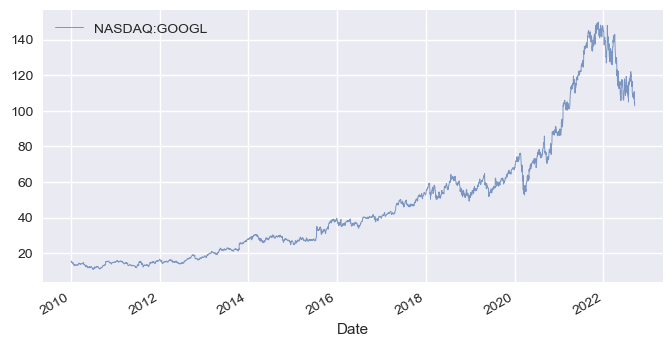

In [26]:
plt.style.use('seaborn')

df['Close'].plot(figsize=(8,4), label='NASDAQ:GOOGL', alpha=0.7, linewidth=0.7)

plt.legend()
plt.show()

중간에 급격히 주가가 떨어지는 구간들이 보이지만, 결국은 시간이 지나면서 회복하고 상승했습니다. 그런데 언제 떨어지고, 언제 회복할지 알 수 있으면 더 좋겠습니다. 현미경으로 짧은 단위의 미세한 관찰을 해보면 어떨까요?

시계열 데이터에는 '자기상관성(Autocorrelation)'에 대한 정보가 내포되어 있습니다. 주가의 경우 그것이 매우 강하게 나타나죠. 아래 그래프는 각각 '오늘을 기점으로 하루씩 멀어지면서 하루 간격의 상관관계'를 보여주는  Autocorrelation'과 '오늘을 기점으로 하루씩 멀어지면서 오늘과 비교 날짜 간의 상관관계'를 보여주는 Partial Autocorrelation'을 보여줍니다.


### 2-2. 자기상관성

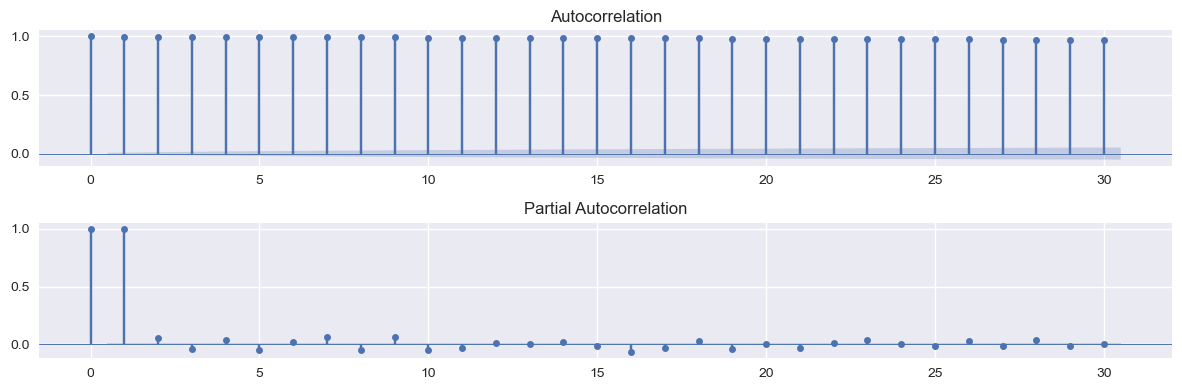

In [32]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Close'], lags=30, ax=ax1, alpha=0.7, linewidth=0.7)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Close'], lags=30, ax=ax2, alpha=0.7, linewidth=0.7)

plt.tight_layout()
plt.show()

즉, 'Autocorrelation' 그래프는 '오늘과 오늘', '오늘과 어제', '어제와 그저께',... 의 상관계수를 나열한 것이고, 'Partial Autocorrelation' 그래프는 '오늘과 오늘', '오늘과 어제', '오늘과 그저께',... 의 상관계수를 나열한 것입니다. 두 그래프에서 x축 0은 '오늘'을 의미하며 우측 끝의 30은 '30일 전'을 의미합니다.

이렇게 두 그래프를 높고 보면, '오늘과 어제', '어제와 그저께'처럼 하루 간격의 주가는 서로 매우 관련이 높은 반면(Autocorrelation), '오늘과 그저께'처럼 이틀 이상 간격의 주가는 서로 관련성이 매우 떨어집니다(Partial Autocorrelation).

그렇다면 우리는 어제 주가를 보고 오늘 주가를 예측할 수 있을 것 같습니다. 기간이 짧을수록 예측력이 높아진다는 것이니까요.

그런데, 이 해석의 반은 맞고 반은 틀렸습니다. 전체 시계열 중 어제의 주가는 오늘의 주가와 밀접한 관련이 있음은 사실이나, 이는 어제의 주가에 강한 영향을 받아서 그렇다고 볼 수는 없습니다. 전체 일별 주가 중 오늘의 주가와 가장 유사한 것은 어제의 주가라서, 그리고 모든 기간에 대해 이러한 관계('각 기간에 대한 오늘과 어제 주가가 가장 유사하다')가 동일하게 나타나기 때문이라 보는 것이 더 적절해 보입니다.

그리고 우리는 이렇게 하루 간격의 강한 상관성을 보이는 데이터에 대해 '추세가 있다'라고 합니다. 일반적으로 주가의 움직임을 두고, '하락장이다' 혹은 '상승장이다'라고 말하는 것은 주가에는 언제나 '추세'가 관측되기 때문입니다.

추세는 장기적으로 움직임을 예상하기에 좋은 근거가 되지만 단기적으로는 오히려 판단을 더 어렵게 합니다. 추세가 왜 발생했는가, 추세가 언제 꺾일 것인가, 혹은 현재 추세가 꺾인 것이 맞는가? 에 대해서는 주가 자체만 놓고 보기보다 거시 경제나 기업 내부 악재 등의 외부 요인을 함께 봐야 하기 때문입니다.

## Step 3. 차분 데이터

### 3-1. 차분 데이터 시각화

그래서 단기적 움직임을 주가로 파악하기 위해서는 추세를 제거한 정보를 확인해볼 필요가 있습니다. 추세를 제거하고 매일의 가격 움직임이 서로 관련이 있는가? 를 보기 위해서는 다양한 방법을 사용할 수 있겠지만 가장 간단하게는 '차분(미분)'을 하면 됩니다. 단, 1회 차분으로  추세가 사라질 수도 있고, 그렇지 않을 수도 있습니다. 시각적으로 혹은 통계적으로 확인해서 여전히 추세가 남아있다면 한번 더 차분을 수행하거나 log변환 후 차분하게 되면 일반적으로 추세는 완전히 사라질 수 있습니다. 주가 데이터의 경우 1회 차분으로 충분히 추세는 제거됩니다.

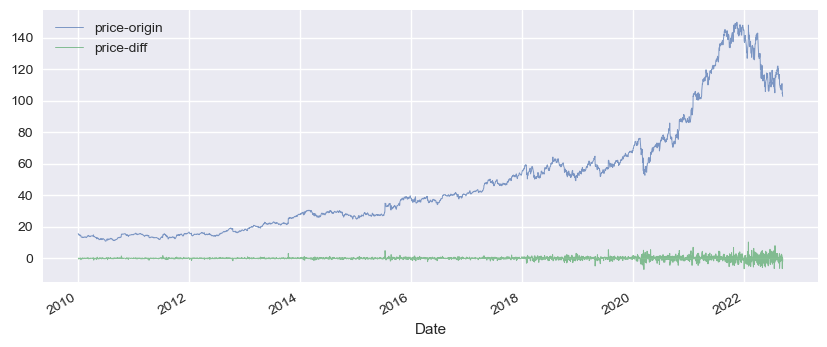

In [34]:
df_diff = df['Close'].diff().dropna()

plt.figure(figsize=(10,4))

df['Close'].plot(label='price-origin', alpha=0.7, linewidth=0.7)
df_diff.plot(label='price-diff', alpha=0.7, linewidth=0.7)

plt.legend()
plt.show()

차분을 통해 단위당 변화량을 확인할 수 있습니다. 주가를 1회 차분한 데이터(price-diff)는 매일의 가격 변화량을 보여줍니다. 즉 각 x좌표에 대한 y축은 어제 대비 오늘 주가가 얼마나 올랐는가? 혹은 얼마나 내렸는가?를 보여줍니다.

### 3-2. 차분 데이터의 자기상관성

 추세를 제거한 데이터에서 다시 한번 Autocorrelation과 Partial Autocorrelation을 확인할 수 있습니다.

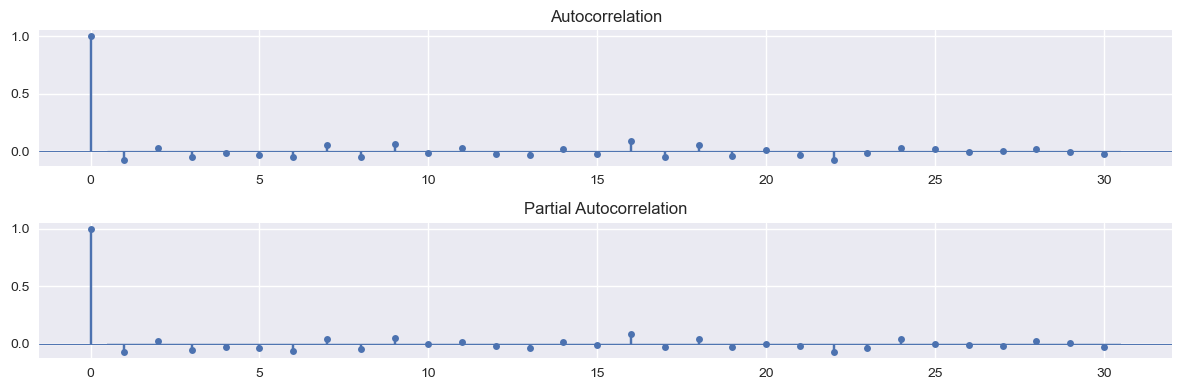

In [35]:
fig = plt.figure(figsize=(12,4))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_diff, lags=30, ax=ax1, alpha=0.7, linewidth=0.7)

ax2 = fig.add_subplot(212)
fig = plot_pacf(df_diff, lags=30, ax=ax2, alpha=0.7, linewidth=0.7)

plt.tight_layout()
plt.show()

주가 데이터에서 추세가 제거되면 이렇게 두 방식(Autocorrelation, Partial Autocorrelation) 모두에서 각 시점 간 의미 있는 관계 역시 사라지게 됩니다. 즉 매일의 가격 변화는 하루 전, 이틀 전, 일주일 전의 가격 변화와 상관성이 매우 떨어지는 것이며 이는 오늘의 주가가 어떨게 될지는 과거의 주가 변화로부터 파악할 수 없는 정보임을 의미합니다. 어제 5% 올랐다고 해서 오늘 5% 오르지 못할 이유가 없으며 반대로 5% 떨어지는 것도 가능합니다. 주가에만 근거한다면 오늘의 가격 변화는 모두 "우연"이라는 것입니다.

- 하루하루의 가격 변화는 랜덤
- 누적되면서 추세를 만들면 추세따라 예측이 가능하지만, 랜덤으로 만들어지는 추세는 후행지표이므로 추세를 학습하는 알고리즘은 후행지표를 따라가는꼴

### 3-3. 정상성

시계열 데이터에 대한 통계분석 모형은 일반적으로 정상성을 가정하고 있습니다. 정상성이란 시점에 관계없이 통계적 특성(평균, 분산)이 변하지 않고 일정한 성질을 의미합니다.

정상성을 검정하기 위해 ADF Test를 실시할 수 있으며, 파이썬에서는 statsmodels에서 제공하는 adfuller 함수를 사용합니다.

> ADF Test
- 귀무가설 : 정상 시계열이 아니다.
- 연구가설 : 정상 시계열이다.

(*사실, ADF Test는 단위근의 존재 여부를 검정하는 검사입니다. 귀무가설은 '단위근이 존재한다.' 이며, 단위근이 존재하면 정상 시계열이 아닙니다.)

In [18]:
def check_stationarity(series):
    res = adfuller(series.values)
    
    print(f'ADF Statistic: {res[0]}')
    print(f'p-value : {res[1]}')
    print(f'Critical Value : \
                            \n\t(1%) {res[4]["1%"]}\
                            \n\t(5%) {res[4]["5%"]}\
                            \n\t(10%) {res[4]["10%"]}')

In [38]:
# 종가데이터
check_stationarity(df['Close'])

ADF Statistic: -0.14103125643667688
p-value : 0.9451951813990677
Critical Value :                             
	(1%) -3.432411939659599                            
	(5%) -2.862451039047868                            
	(10%) -2.567254966919707


쉽게 예상할 수 있듯이 종가 데이터에는 추세가 강하게 존재하며, 각 시점에 따라 움직임의 폭이 매우 다릅니다. 즉, 통계적 특성이 시점에 따라 변하기 때문에 정상 시계열이 아닙니다. 

ADF Test 결과(p-value>0.5)를 통해 통계적으로도 이를 확인할 수 있었습니다.

In [39]:
# 종가-차분데이터
check_stationarity(df_diff)

ADF Statistic: -11.92624619333717
p-value : 4.899383336275813e-22
Critical Value :                             
	(1%) -3.432411939659599                            
	(5%) -2.862451039047868                            
	(10%) -2.567254966919707


반면, 일별 종가 변화량을 의마하는 차분한 데이터는 ADF Test 결과 p-value<0.5 이므로 귀무가설을 기각할 수 있습니다. 즉, 매일의 가격변화는 정상성을 띕니다. 이는 하루 하루의 가격 변화는 특정 범위 내에서 추세가 없는 불규칙한 특성을 띄다는 것을 의미합니다.

## Step 4. 결론

 주가라는 단일 데이터만 고려할 수 있는 상황이라면 '추세'는 유일하게 과거와 현재를 이어주는 근거가 되고, 이 근거를 기반으로 앞으로의 주가도 예상해볼 수 있습니다. 다시 말해 지난 1년간 추세가 하락 국면을 보였다면 앞으로 1년도 추세에 따라 '여전히' 그럴 수 있지만 지난 10년간 장기적으로 상승했다면 현재의 하락 국면은 일시적일 수 있습니다.

또한 추세는 언제나 방향을 꺾을 수도 있습니다. 추세는 과거부터 현재까지 만들어진, 이미 완성된 데이터를 기반으로 형성되므로 앞으로 5년, 10년간 새로운 데이터가 만들어지면서 지난 10년간 형성된 추세는 더 강해 지거나 완전히 역전되는 것은 충분히 가능합니다.

정리하면, 주가 데이터만 보고 투자를 한다면 '추세'가 유일한 지침일 수 있으나 그 '추세'는 언제 바뀌어도 이상하지 않습니다. 그렇기 때문에 꼭 단타가 아니더라도 '지금까지 쭉 올랐으니까', 혹은 '폭락했으니까 이제 오를거야'와 같은 생각이 장기 투자의 근거가 되고 있다면, 단타나 장기 보유나 모두 손실 가능성을 포함하고 있습니다.